In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=50)

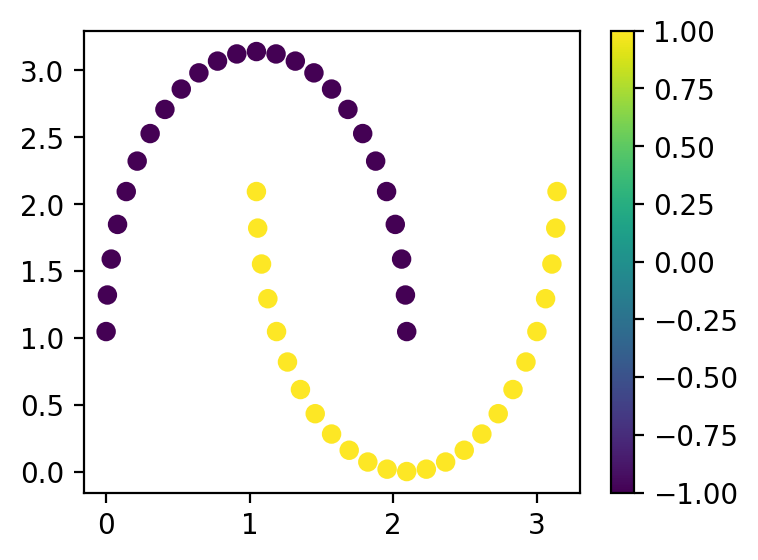

In [2]:
def normalize(x):
    """
    Переводит значения в интервал от 0 до pi
    """
    min_ = x.min()
    max_ = x.max()
    return np.pi * (x - min_) / (max_ - min_)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])
y = y * 2 - 1
print

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

In [3]:
dev = qml.device("default.qubit", 2)
#Задае начальные условия + запутываем состояния
def encoding(x1, x2):
    qml.RY(x1, wires=0)
    qml.RY(x2, wires=1)
    qml.RZ(x1, wires=0)
    qml.RZ(x2, wires=1)
    qml.CZ(wires=[0, 1])

In [6]:
#Создает слой с параметрами тетта (фращает по 3 осям 0 кубит, потом 1, свзявает гейтом CZ)
def layer(theta):
    qml.Rot(theta[0, 0], theta[0, 1], theta[0, 2], wires=0)
    qml.Rot(theta[1, 0], theta[1, 1], theta[1, 2], wires=1)
    qml.CZ(wires=[0, 1])

In [7]:
#Создает слой на вар схеме в зависимости от параметров q для точки x
@qml.qnode(dev) 
def node(x1, x2, q):
    encoding(x1, x2)
    for q_ in q:
        layer(q_)

    return qml.expval(qml.PauliZ(0) @ qml.PauliY(1)) #?


C:\Users\Anton\AppData\Local\Temp\ipykernel_19920\2865651942.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


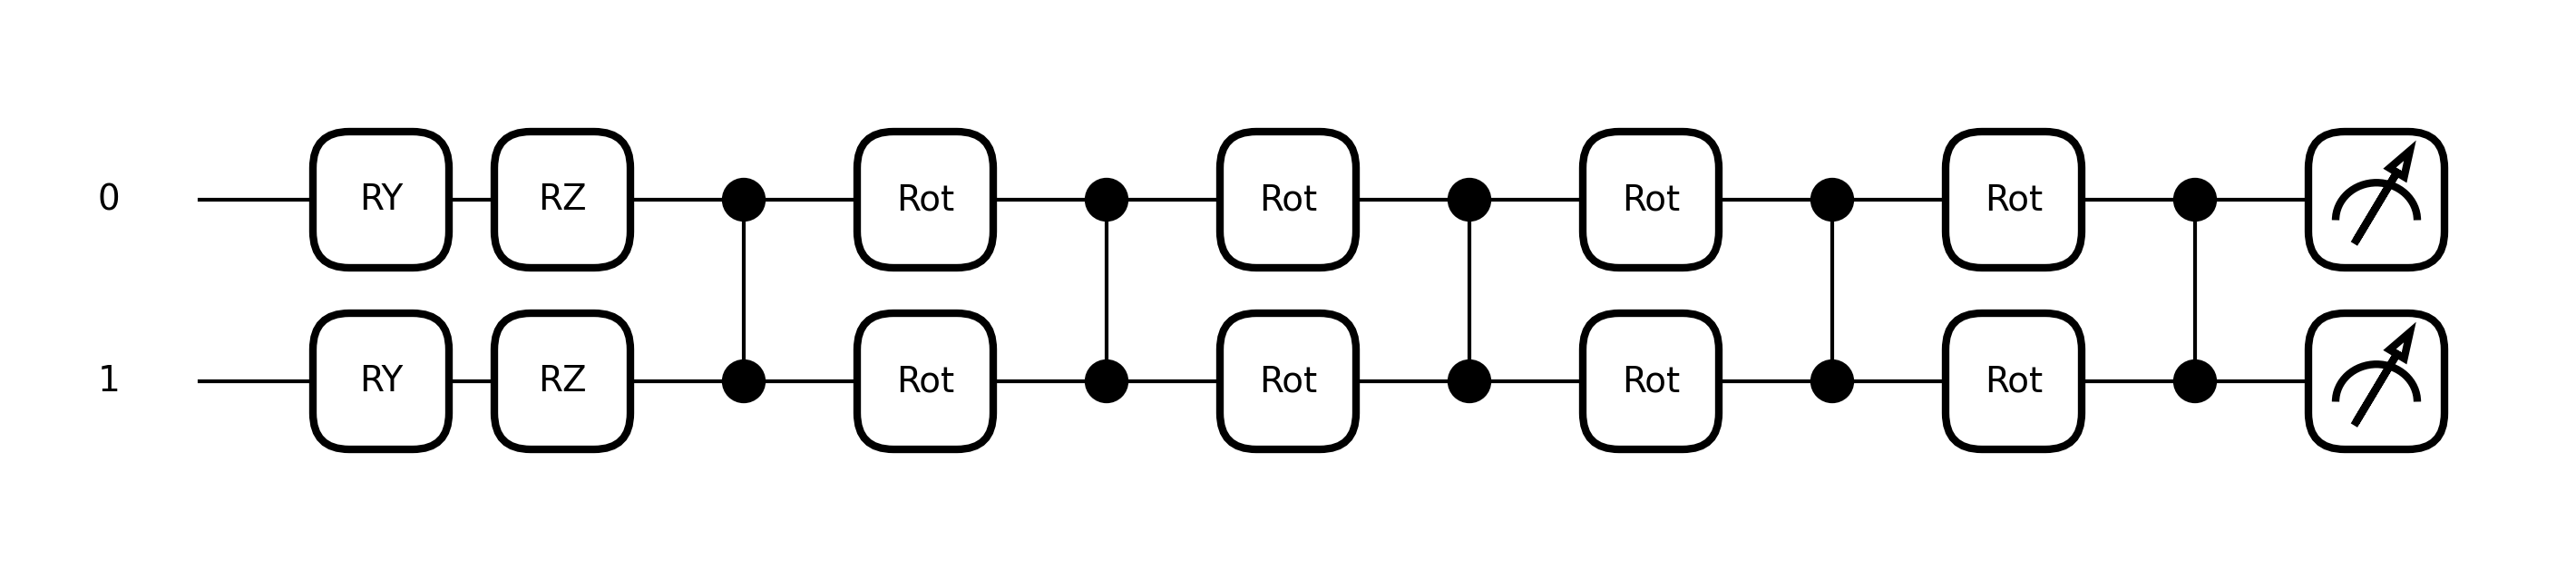

In [8]:
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)
fig, ax = qml.draw_mpl(node)(x[0, 0], x[0, 1], q[0])
fig.show()

In [34]:
#варицационную схему для одной пары x с на параметрах q, условно по параметрам и координатам определяет "цвет" луны
def apply_node(x, q):
    res = []

    for x_ in x:
        vqc_output = node(x_[0], x_[1], q[0])
        res.append(vqc_output + q[1])

    return res

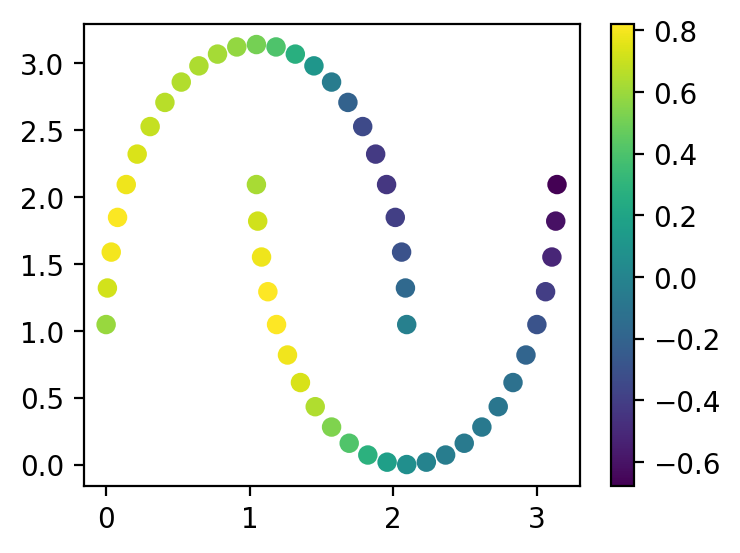

In [36]:
np.random.seed(42)
q = (np.random.uniform(-np.pi, np.pi, size=(4, 2, 3)), 0.0)

plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))

plt.colorbar(cb)
plt.show()

In [11]:
def cost(q, x, y):# создаем функцию потерь (в нешем случае это среднее квадратичное)
    preds = np.array(apply_node(x, q))
    return np.mean(np.square(preds - y))

In [12]:
def acc(q, x, y): #Поэтому для оценки модели в целом мы будем использовать точность(каво нахуй?)
    preds = np.sign(apply_node(x, q))
    res = 0
    for p_, y_ in zip(preds, y):
        if np.abs(y_ - p_) <= 1e-2:
            res += 1

    return res / y.shape[0]

In [33]:
q =[(np.random.uniform(-np.pi, np.pi, size=(4, 2, 3))), 0.0]
q1 = np.array([(np.random.randint(-np.pi, np.pi, size=(4, 2, 3))), 0.0])
q2 = np.array([1,2,3])
print(type(q1))
print(q1[1])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [17]:
opt = qml.optimize.GradientDescentOptimizer(stepsize=0.05)
acc_ = []
cost_ = []
ii = []
for i in range(75):
    batch = np.random.randint(0, len(x), (50,))
    x_batch = x[batch, :]
    y_batch = y[batch]
    def a(k):
        return(cost(k, x_batch, y_batch))
  #  q, e = opt.step_and_cost(a, q)
    #print(q)
    #print("--------------------------------------------------------")
    #q = opt.step(lambda q_: cost(q_, x_batch, y_batch), q)
    q = opt.step(a, q)
    #print(q)
    #print("--------------------------------------------------------")
    if i % 5 == 0:
        ii.append(i)
        acc_.append(acc(q, x, y))        
        cost_.append(cost(q, x, y))
        #cost_.append(e)

KeyboardInterrupt: 

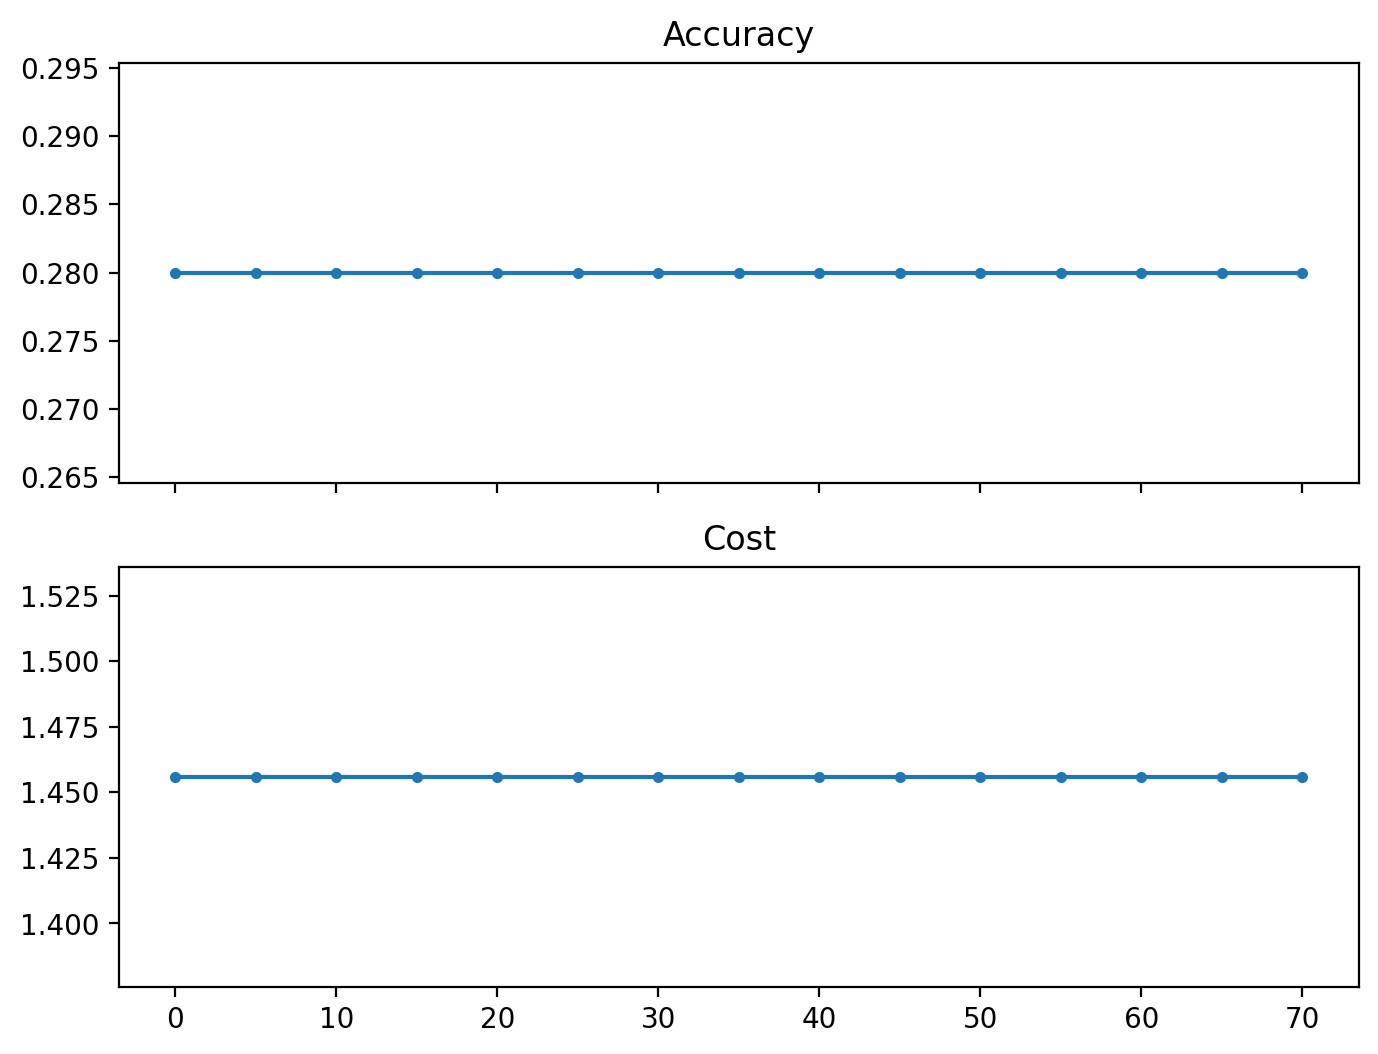

In [15]:
f, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].plot(ii, acc_, ".-")
ax[0].set_title("Accuracy")
ax[1].plot(ii, cost_, ".-")
ax[1].set_title("Cost")
plt.show()

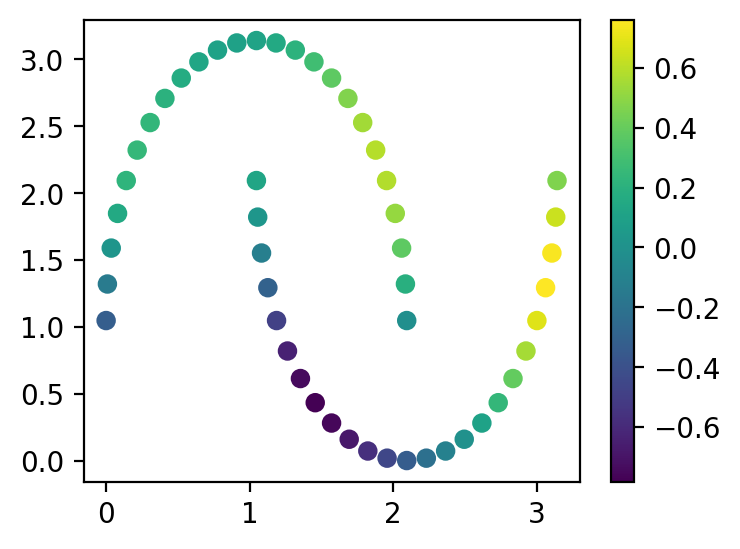

In [16]:
plt.figure(figsize=(4, 3))
cb = plt.scatter(x[:, 0], x[:, 1], c=apply_node(x, q))
plt.colorbar(cb)
plt.show()